## FastNeRF: High-Fidelity Neural Rendering at 200 FPS

Original Paper: [FastNeRF](https://openaccess.thecvf.com/content/ICCV2021/html/Garbin_FastNeRF_High-Fidelity_Neural_Rendering_at_200FPS_ICCV_2021_paper.html)
, 2021

NeRF showed its ability to encode complex 3D environments that can be rendered photorealistically from novel viewoints. However, rendering these images is very computationally demanding. To improve the inference speed, the core insight of this approach consistes of factoring NeRF into tow neural networks

 - $F_{pos}$: positioin-dependent network that produces a deep radiance map
 - $F_{dir}$: direction dependent network that produces weights

The estimated color in the scene at the specified position and as seen from the specified direction is produced by inner product of the weights and the deep radiance map. ($F_{pos} \cdot F_{dir}$)

Another important techniqe is caching. We don't address this here, refer to the original paper. 
![fastnerf](illustration_fastnerf.png)

Vanilla NeRF requires calling $F_{NeRF}$ a loarge number of times to produce a single image. For example, each pixel requires N=192 samples, that means nearly 400 milion calls to $F_{NeRF}$ are required to compute an image of 1080p image.  



FastNeRF is inspired from traditional rendering equation that involues an integral of $fr(p,d,w_i)$ (reflectance function captureing the material properties at position p) and $L_i(p,w_i)$ (amount of light reaching p from direction $w_i$) and n ( direction of the surface normal at p). The efficient way to calcuate this integral is to use spherical harmonicsand in this casd, it boils down to a dot product bwteen the coefficients of both spherical harmonics approximations. 

[Brian Cabral, Nelson Max, and Rebecca Springmeyer. Bidi-rectional reﬂection functions from surface bump maps.21(4):273–281, Aug. 1987] 

As shown in the righ figure, networks:
 - $F_{pos}:p \mapsto{\sigma, (u,v,w)}$
 - $F_{dir}:d \mapsto{\beta}$

 where $u,v,w$ are D-dimensional vectors that form a deep radiance map. $\beta$ is also a D-dimensional vecor of weights for the D components of the deep radiance map. The color is estiamted as:
 $$
 c=(r,g,b)=\sum_{i=1}^D{\beta_i (u_i,v_i,w_i)}=\bold{\beta^T\cdot(u,v,w)}
 $$ 

In [1]:
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
training_dataset = torch.from_numpy(np.load('../datasets/training_data_800x800.pkl',allow_pickle=True))
testing_dataset = torch.from_numpy(np.load('../datasets/testing_data_800x800.pkl',allow_pickle=True))

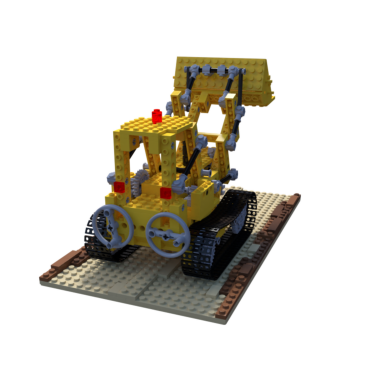

First 4 training samples camera position, viewing direction expressed as a 3D Cartesian unit:
 tensor([[-0.0538,  3.8455,  1.2081,  0.3340, -0.9418,  0.0390],
        [-0.0538,  3.8455,  1.2081,  0.3333, -0.9420,  0.0390],
        [-0.0538,  3.8455,  1.2081,  0.3326, -0.9423,  0.0390],
        [-0.0538,  3.8455,  1.2081,  0.3319, -0.9425,  0.0390]])


In [3]:
#image size
H, W=800, 800
img_index = 1

#display few samples from the training dataset
img_data = training_dataset[img_index * H * W: (img_index + 1) * H * W, 6:]  
img = img_data.reshape(H,W,3)
plt.imshow(img)
plt.axis('off')
plt.show()

print(f"First 4 training samples camera position, viewing direction expressed as a 3D Cartesian unit:\n {training_dataset[:4,:6]}")

In [3]:
def compute_accumulated_transmittance(alphas):
    accumulated_transmittance = torch.cumprod(alphas, 1)
    return torch.cat((torch.ones((accumulated_transmittance.shape[0], 1), device=alphas.device),
                      accumulated_transmittance[:, :-1]), dim=-1)

def render_rays(nerf_model, ray_origins, ray_directions, hn=0, hf=0.5, nb_bins=192):
    device = ray_origins.device
    t = torch.linspace(hn, hf, nb_bins, device=device).expand(ray_origins.shape[0], nb_bins)
    # Perturb sampling along each ray.
    mid = (t[:, :-1] + t[:, 1:]) / 2.
    lower = torch.cat((t[:, :1], mid), -1)
    upper = torch.cat((mid, t[:, -1:]), -1)
    u = torch.rand(t.shape, device=device)
    t = lower + (upper - lower) * u  # [batch_size, nb_bins]
    delta = torch.cat((t[:, 1:] - t[:, :-1], torch.tensor(
        [1e10], device=device).expand(ray_origins.shape[0], 1)), -1)

    # Compute the 3D points along each ray
    x = ray_origins.unsqueeze(1) + t.unsqueeze(2) * ray_directions.unsqueeze(1)
    # Expand the ray_directions tensor to match the shape of x
    ray_directions = ray_directions.expand(nb_bins, ray_directions.shape[0], 3).transpose(0, 1)
    colors, sigma = nerf_model(x.reshape(-1, 3), ray_directions.reshape(-1, 3))
    alpha = 1 - torch.exp(-sigma.reshape(x.shape[:-1]) * delta)  # [batch_size, nb_bins]
    weights = compute_accumulated_transmittance(1 - alpha).unsqueeze(2) * alpha.unsqueeze(2)
    c = (weights * colors.reshape(x.shape)).sum(dim=1)
    weight_sum = weights.sum(-1).sum(-1)  # Regularization for white background
    return c + 1 - weight_sum.unsqueeze(-1)

### Fast NeRF model implementation

THe postion in 3D has size 3. The output of position embedding will has size [embedding_dim_pos*2*3] (one part from sin function and one part from cosine function)
This neural network then has input embedding output and position x so the size is [embedding_dim_pos*2*3+3]. It has 8 hidden layers with size 384. The activation function is ReLU. The final layer is [3*D+1] size which means it predict D set of (u,v,w) and one simga. 


In [4]:
class FastNerf(nn.Module):
    def __init__(self, embedding_dim_pos=10, embedding_dim_direction=4, hidden_dim_pos=384, hidden_dim_dir=128, D=8):
        super(FastNerf, self).__init__()

        self.Fpos = nn.Sequential(nn.Linear(embedding_dim_pos * 6 + 3, hidden_dim_pos), nn.ReLU(),
                                  nn.Linear(hidden_dim_pos, hidden_dim_pos), nn.ReLU(),
                                  nn.Linear(hidden_dim_pos, hidden_dim_pos), nn.ReLU(),
                                  nn.Linear(hidden_dim_pos, hidden_dim_pos), nn.ReLU(),
                                  nn.Linear(hidden_dim_pos, hidden_dim_pos), nn.ReLU(),
                                  nn.Linear(hidden_dim_pos, hidden_dim_pos), nn.ReLU(),
                                  nn.Linear(hidden_dim_pos, hidden_dim_pos), nn.ReLU(),
                                  nn.Linear(hidden_dim_pos, 3 * D + 1), )

        self.Fdir = nn.Sequential(nn.Linear(embedding_dim_direction * 6 + 3, hidden_dim_dir), nn.ReLU(),
                                  nn.Linear(hidden_dim_dir, hidden_dim_dir), nn.ReLU(),
                                  nn.Linear(hidden_dim_dir, hidden_dim_dir), nn.ReLU(),
                                  nn.Linear(hidden_dim_dir, D), )

        self.embedding_dim_pos = embedding_dim_pos
        self.embedding_dim_direction = embedding_dim_direction
        self.D = D

    @staticmethod
    def positional_encoding(x, L):
        out = [x]
        for j in range(L):
            out.append(torch.sin(2 ** j * x))
            out.append(torch.cos(2 ** j * x))
        return torch.cat(out, dim=1)

    def forward(self, o, d):
        sigma_uvw = self.Fpos(self.positional_encoding(o, self.embedding_dim_pos))
        sigma = torch.nn.functional.softplus(sigma_uvw[:, 0][..., None])  # [batch_size, 1]
        uvw = torch.sigmoid(sigma_uvw[:, 1:].reshape(-1, 3, self.D))  # [batch_size, 3, D]

        beta = torch.softmax(self.Fdir(self.positional_encoding(d, self.embedding_dim_direction)), -1)
        color = (beta.unsqueeze(1) * uvw).sum(-1)  # [batch_size, 3]
        return color, sigma

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FastNerf().to(device)

num_params = sum(p.numel() for p in model.parameters())
print(f"NeRF model parameter size: {num_params:,}")
print(model.parameters)

NeRF model parameter size: 958,881
<bound method Module.parameters of FastNerf(
  (Fpos): Sequential(
    (0): Linear(in_features=63, out_features=384, bias=True)
    (1): ReLU()
    (2): Linear(in_features=384, out_features=384, bias=True)
    (3): ReLU()
    (4): Linear(in_features=384, out_features=384, bias=True)
    (5): ReLU()
    (6): Linear(in_features=384, out_features=384, bias=True)
    (7): ReLU()
    (8): Linear(in_features=384, out_features=384, bias=True)
    (9): ReLU()
    (10): Linear(in_features=384, out_features=384, bias=True)
    (11): ReLU()
    (12): Linear(in_features=384, out_features=384, bias=True)
    (13): ReLU()
    (14): Linear(in_features=384, out_features=25, bias=True)
  )
  (Fdir): Sequential(
    (0): Linear(in_features=27, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=

## Cache class that help in speeding up rendering process

To accelerate rendering during test time, caching its outputs for a set of inputs that cover the space of the scene is proposed in this paper. 

We uniformly sample $Np$ values for each of the 3 world spcae coordinates (x,y,z)=p within the bounds of $V$ as well as $Nd$ smaple values for each of the ray direction coordinates $(\theta, \phi)=d$ with $\theta \in <0, \pi>$ and $\phi \in <0,2\pi>$. A cache is generated by computing Fast NeRF output for each combination of smapled $p$ and $d$. 

During testing phase, the forward function of this class is called instead of rendering_ray function. This is the point show the memery complexity reduced significantly thanks to its factorized architecture design.
- Fast NeRF with cache: $O(k^3*(1+D\times 3)+l^2*D)$ 
- NeRF: $O(k^3l^2)$.

In [ ]:
class Cache(nn.Module):
    def __init__(self, model, scale, device, Np, Nd):
        super(Cache, self).__init__()

        with torch.no_grad():
            # Position
            x, y, z = torch.meshgrid([torch.linspace(-scale / 2, scale / 2, Np).to(device),
                                      torch.linspace(-scale / 2, scale / 2, Np).to(device),
                                      torch.linspace(-scale / 2, scale / 2, Np).to(device)])
            xyz = torch.cat((x.reshape(-1, 1), y.reshape(-1, 1), z.reshape(-1, 1)), dim=1)
            sigma_uvw = model.Fpos(model.positional_encoding(xyz, model.embedding_dim_pos))
            self.sigma_uvw = sigma_uvw.reshape((Np, Np, Np, -1))
            # Direction
            xd, yd = torch.meshgrid([torch.linspace(-scale / 2, scale / 2, Nd).to(device),
                                     torch.linspace(-scale / 2, scale / 2, Nd).to(device)])
            xyz_d = torch.cat((xd.reshape(-1, 1), yd.reshape(-1, 1),
                               torch.sqrt((1 - xd ** 2 - yd ** 2).clip(0, 1)).reshape(-1, 1)), dim=1)
            beta = model.Fdir(model.positional_encoding(xyz_d, model.embedding_dim_direction))
            self.beta = beta.reshape((Nd, Nd, -1))

        self.scale = scale
        self.Np = Np
        self.Nd = Nd
        self.D = model.D
        
    def forward(self, x, d):
        color = torch.zeros_like(x)
        sigma = torch.zeros((x.shape[0], 1), device=x.device)

        mask = (x[:, 0].abs() < (self.scale / 2)) & (x[:, 1].abs() < (self.scale / 2)) & (x[:, 2].abs() < (self.scale / 2))
        # Position
        idx = (x[mask] / (self.scale / self.Np) + self.Np / 2).long().clip(0, self.Np - 1)
        sigma_uvw = self.sigma_uvw[idx[:, 0], idx[:, 1], idx[:, 2]]
        # Direction
        idx = (d[mask] * self.Nd).long().clip(0, self.Nd - 1)
        beta = torch.softmax(self.beta[idx[:, 0], idx[:, 1]], -1)

        sigma[mask] = torch.nn.functional.softplus(sigma_uvw[:, 0][..., None])  # [batch_size, 1]
        uvw = torch.sigmoid(sigma_uvw[:, 1:].reshape(-1, 3, self.D))  # [batch_size, 3, D]
        color[mask] = (beta.unsqueeze(1) * uvw).sum(-1)  # [batch_size, 3]
        return color, sigma

## Test with pre-trained model

In [ ]:
model.load_state_dict(torch.load('../models/fastnerf_model.pth'))
model.eval()
model.to(device)

cache = Cache(model, 2.2, device, 192, 128)
for img_index in range(200):
    ray_origins = testing_dataset[img_index * H * W: (img_index + 1) * H * W, :3]
    ray_directions = testing_dataset[img_index * H * W: (img_index + 1) * H * W, 3:6]
    regenerated_px_values = render_rays(cache, ray_origins.to(device), ray_directions.to(device), hn=2, hf=6,
                                        nb_bins=192)

    if not os.path.exists('../novel_views/fastnerf'):
        os.makedirs('../novel_views/fastnerf')
    plt.figure()
    plt.imshow(regenerated_px_values.data.cpu().numpy().reshape(H, W, 3).clip(0, 1))
    plt.axis('off')
    plt.savefig(f'novel_views/fastnerf/img_{img_index}.png', bbox_inches='tight')
    plt.close()

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL __main__.FastNerf was not an allowed global by default. Please use `torch.serialization.add_safe_globals([__main__.FastNerf])` or the `torch.serialization.safe_globals([__main__.FastNerf])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.